In [15]:
%cd /data/codes/prep_ps_pykaldi_dev/
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

import pickle
import json
import re

from torch.utils.data import DataLoader
from torch import nn

from src.dataset import PrepDataset
import os

/data/codes/prep_ps_pykaldi_dev


In [16]:
def convert_score_to_color(score, YELLOW_GREEN=80/50, RED_YELLOW=30/50):
    if RED_YELLOW is not None:
        LABEL2ID = {"GREEN": 0, "YELLOW": 1, "RED":2}
        red_index = score < RED_YELLOW
        yellow_index = ((score >= RED_YELLOW).int() & (score < YELLOW_GREEN).int()).bool()
        green_index = score >= YELLOW_GREEN
    else:
        LABEL2ID = {"GREEN": 0, "YELLOW": 1, "RED":1}
        RED_YELLOW = 30/50
        red_index = score < RED_YELLOW
        yellow_index = ((score >= RED_YELLOW).int() & (score < YELLOW_GREEN).int()).bool()
        green_index = score >= YELLOW_GREEN


    score[red_index] = LABEL2ID["RED"]
    score[yellow_index] = LABEL2ID["YELLOW"]
    score[green_index] = LABEL2ID["GREEN"]

    return score

def load_data(data_dir):
    phone_ids = np.load(f'{data_dir}/phone_ids.npy')
    word_ids = np.load(f'{data_dir}/word_ids.npy')
    
    phone_scores = np.load(f'{data_dir}/phone_scores.npy')
    word_scores = np.load(f'{data_dir}/word_scores.npy')
    sentence_scores = np.load(f'{data_dir}/sentence_scores.npy')

    durations = np.load(f'{data_dir}/duration.npy')
    gops = np.load(f'{data_dir}/gop.npy')
    wavlm_features = np.load(f'{data_dir}/wavlm_features.npy')

    relative_positions = np.load(f'{data_dir}/relative_positions.npy')

    return phone_ids, word_ids, phone_scores, word_scores, sentence_scores, durations, gops, wavlm_features, relative_positions


In [17]:
from torch.utils.data import Dataset, DataLoader
import torch

class PrepDataset(Dataset):
    def __init__(self, phone_ids, word_ids, phone_scores, word_scores, sentence_scores, durations, gops, wavlm_features, relative_positions):
        self.phone_ids = phone_ids
        self.word_ids = word_ids

        self.phone_scores = phone_scores
        self.word_scores = word_scores
        self.sentence_scores = sentence_scores

        self.gops = gops
        self.durations = durations
        self.wavlm_features = wavlm_features
        self.relative_positions = relative_positions

    def __len__(self):
        return self.phone_ids.shape[0]
    
    def parse_data(self, phone_ids, word_ids, phone_scores, word_scores, sentence_scores, durations, gops, wavlm_features, relative_positions):
        phone_ids = torch.tensor(phone_ids)
        word_ids = torch.tensor(word_ids)

        phone_scores = torch.tensor(phone_scores).float().clone()
        word_scores = torch.tensor(word_scores).float().clone()
        sentence_scores = torch.tensor(sentence_scores).float().clone()

        phone_scores[phone_scores != -1] /= 50
        word_scores[word_scores != -1] /= 50
        sentence_scores /= 50

        durations = torch.tensor(durations)
        gops = torch.tensor(gops)
        wavlm_features = torch.tensor(wavlm_features)
        relative_positions = torch.tensor(relative_positions)

        features = torch.concat([gops, durations.unsqueeze(-1), wavlm_features], dim=-1)        
        return {
            "features": features,
            "phone_ids": phone_ids,
            "word_ids": word_ids,
            "phone_scores":phone_scores,
            "word_scores":word_scores,
            "sentence_scores":sentence_scores,
            "relative_positions": relative_positions
        }
        
    def __getitem__(self, index):
        phone_ids = self.phone_ids[index]
        word_ids = self.word_ids[index]

        phone_scores = self.phone_scores[index]
        word_scores = self.word_scores[index]
        sentence_scores = self.sentence_scores[index]

        gops = self.gops[index]
        durations = self.durations[index]
        wavlm_features = self.wavlm_features[index]
        relative_positions = self.relative_positions[index]

        return self.parse_data(
            phone_ids=phone_ids,
            word_ids=word_ids,
            phone_scores=phone_scores,
            word_scores=word_scores,
            sentence_scores=sentence_scores,
            gops=gops,
            durations=durations,
            wavlm_features=wavlm_features,
            relative_positions=relative_positions
        )

In [18]:
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
# from src.model import GOPT

train_dir = "/data/codes/apa/train/exps/features/train"

phone_ids, word_ids, phone_scores, word_scores, \
    sentence_scores, durations, gops, wavlm_features, relative_positions = load_data(train_dir)
trainset = PrepDataset(
    phone_ids, word_ids, 
    phone_scores, word_scores, sentence_scores, 
    durations, gops, wavlm_features, relative_positions
    )

trainloader = DataLoader(trainset, batch_size=8, shuffle=True, drop_last=False)

test_dir = "/data/codes/apa/train/exps/features/test"
phone_ids, word_ids, phone_scores, word_scores, \
    sentence_scores, durations, gops, wavlm_features, relative_positions = load_data(test_dir)
testset = PrepDataset(
    phone_ids, word_ids, 
    phone_scores, word_scores, sentence_scores, 
    durations, gops, wavlm_features, relative_positions
    )

testloader = DataLoader(testset, batch_size=8, shuffle=False, drop_last=True)

In [19]:
import math
import warnings
import torch
import torch.nn as nn
import numpy as np

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        tensor.uniform_(2 * l - 1, 2 * u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        tensor.clamp_(min=a, max=b)
        
        return tensor

def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


import torch.nn.functional as F

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim: int, drop_rate=0.1) -> None:
        super(AdditiveAttention, self).__init__()

        self.query_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.bias = nn.Parameter(
            torch.rand(hidden_dim).uniform_(-0.1, 0.1))
        
        self.score_proj = nn.Linear(hidden_dim, 1)

    def forward(self, query, key, value):
        score = self.score_proj(torch.tanh(self.key_proj(key) + self.query_proj(query) + self.bias)).squeeze(-1)
        attn = F.softmax(score, dim=-1)
        context = torch.bmm(attn.unsqueeze(1), value)
        return context, attn

class DepthwiseSeparableConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.depthwise_conv = nn.Conv1d(
            in_channels=in_channels, out_channels=in_channels,
            kernel_size=kernel_size, groups=in_channels, 
            padding=kernel_size//2, bias=False
        )

        self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0, bias=True)

    def forward(self, x):
        x = x.transpose(1,2)
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = x.transpose(1,2)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Args:
            x: `embeddings`, shape (batch, max_len, d_model)

        Returns:
            `encoder input`, shape (batch, max_len, d_model)
        """
        return self.pe[:, : x.size(1)]
    
class PrepModel(nn.Module):
    def __init__(self, embed_dim, num_heads, depth, input_dim=84, max_length=50, num_phone=40, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_phone = num_phone

        # self.pos_embed = nn.Parameter(torch.zeros(1, max_length+1, self.embed_dim))
        self.pos_embed = PositionalEncoding(d_model=self.embed_dim, max_len=max_length)
        # trunc_normal_(self.pos_embed, std=.02)
        
        self.phn_proj = nn.Linear(num_phone, embed_dim)
        self.in_proj = nn.Linear(input_dim, embed_dim)
        
        self.phone_encoders = nn.ModuleList(
            [
                Block(dim=embed_dim, num_heads=num_heads) 
                for i in range(depth)
                ]
            )

        self.ds_conv = DepthwiseSeparableConvolution(
            in_channels=embed_dim, 
            out_channels=embed_dim, 
            kernel_size=3
        )
        
        self.word_encoders = nn.ModuleList(
            [
                Block(dim=embed_dim, num_heads=num_heads) 
                for i in range(1)
                ]
            )
        
        self.rel_pos_embed = nn.Embedding(
            num_embeddings=5, embedding_dim=embed_dim)
        
        self.utt_encoders = nn.ModuleList(
            [
                Block(dim=embed_dim, num_heads=num_heads) 
                for i in range(1)
                ]
            )
        
        self.utt_addi = AdditiveAttention(hidden_dim=embed_dim)

        self.phone_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, 1))
        self.utt_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, 1))
        self.word_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, 1))

    def forward(self, x, phn, rel_pos):
        batch_size, seq_length, embedd_dim = x.shape[0], x.shape[1], x.shape[2]

        phn_one_hot = torch.nn.functional.one_hot(phn.long()+1, num_classes=self.num_phone).float()
        phn_embed = self.phn_proj(phn_one_hot)

        if self.embed_dim != self.input_dim:
            x = self.in_proj(x)

        # p_x = x + phn_embed + self.pos_embed[:,:seq_length,:]
        p_x = x + phn_embed + self.pos_embed(x)
        for block in self.phone_encoders:
            p_x = block(p_x)
        phone_score = self.phone_head(p_x)

        w_x = p_x + self.rel_pos_embed(rel_pos)
        w_x = self.ds_conv(w_x)
        for block in self.word_encoders:
            w_x = block(w_x)
        
        word_score = self.word_head(w_x)

        for block in self.utt_encoders:
            w_x = block(w_x)

        u_x = p_x + w_x

        u_x, attn = self.utt_addi(query=u_x, key=u_x, value=u_x)
        utt_score = self.utt_head(u_x.squeeze(1))

        return utt_score, phone_score, word_score
    

In [20]:
embed_dim=32
num_heads=1
depth=3
input_dim=853
num_phone=43
max_length=128

lr=1e-3
weight_decay=5e-7
betas=(0.95, 0.999)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

gopt_model = PrepModel(
    embed_dim=embed_dim, num_heads=num_heads, 
    depth=depth, input_dim=input_dim, 
    max_length=max_length, num_phone=num_phone, dropout=0.1).to(device)

trainables = [p for p in gopt_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(
    trainables, lr, 
    weight_decay=weight_decay, 
    betas=betas
)

loss_fn = nn.MSELoss()

In [21]:
def valid_phn(predict, target):
    preds, targs = [], []

    for i in range(predict.shape[0]):
        for j in range(predict.shape[1]):
            if target[i, j] >= 0:
                preds.append(predict[i, j])
                targs.append(target[i, j])
    targs = np.array(targs)
    preds = np.array(preds)

    mse = np.mean((targs - preds) ** 2)
    mae = np.mean(np.abs(targs - preds))
    corr = np.corrcoef(preds, targs)[0, 1]
    return mse, mae, corr


In [22]:
def valid_wrd(predict, target, word_id):
    preds, targs = [], []

    for i in range(target.shape[0]):
        prev_w_id, start_id = 0, 0
        # for each token
        for j in range(target.shape[1]):
            cur_w_id = word_id[i, j].int()
            # if a new word
            if cur_w_id != prev_w_id:
                # average each phone belongs to the word
                preds.append(np.mean(predict[i, start_id: j].numpy(), axis=0))
                targs.append(np.mean(target[i, start_id: j].numpy(), axis=0))

                if cur_w_id == -1:
                    break
                else:
                    prev_w_id = cur_w_id
                    start_id = j

    preds = np.array(preds)
    targs = np.array(targs).round(2)

    word_mse = np.mean((preds - targs) ** 2)
    wrd_mae = np.mean(np.abs(preds - targs))
    word_corr = np.corrcoef(preds, targs)[0, 1]
    
    return word_mse, wrd_mae, word_corr

In [23]:
def valid_utt(predict, target):
    utt_mse = np.mean(((predict[:, 0] - target[:, 0]) ** 2).numpy())
    utt_mae = np.mean((np.abs(predict[:, 0] - target[:, 0])).numpy())
    
    utt_corr = np.corrcoef(predict[:, 0], target[:, 0])[0, 1]
    return utt_mse, utt_mae, utt_corr


In [24]:
def to_device(batch, device):
    features = batch["features"].to(device)
    phone_ids = batch["phone_ids"].to(device)
    relative_positions = batch["relative_positions"].to(device)
    word_ids = batch["word_ids"]
    
    phone_labels = batch["phone_scores"].to(device)
    word_labels = batch["word_scores"].to(device)
    utterance_labels = batch["sentence_scores"].to(device)

    return features, phone_ids, word_ids, relative_positions, phone_labels, word_labels, utterance_labels

def to_cpu(preds, labels):
    preds = preds.detach().cpu().squeeze(-1)
    labels = labels.detach().cpu()

    return preds, labels

In [25]:
def load_pred_and_label(pred_path, label_path):
    pred = np.load(pred_path)
    label = np.load(label_path)

    pred = np.concatenate(pred)
    label = np.concatenate(label)
    index = label != -1    
    
    return label[index], pred[index]

def save_confusion_matrix_figure(
        fig_path, pred_path, label_path, YELLOW_GREEN=80/50, RED_YELLOW=30/50):
    
    label, pred = load_pred_and_label(pred_path=pred_path, label_path=label_path)
    
    actual = convert_score_to_color(
        torch.from_numpy(label), YELLOW_GREEN=YELLOW_GREEN, RED_YELLOW=RED_YELLOW)
    
    predicted = convert_score_to_color(
        torch.from_numpy(pred), YELLOW_GREEN=YELLOW_GREEN, RED_YELLOW=RED_YELLOW)
    
    cfs_mtr = confusion_matrix(actual, predicted)
    cfs_mtr = cfs_mtr / cfs_mtr.sum(axis=1, keepdims=True)
    if RED_YELLOW is not None:
        cm_display = ConfusionMatrixDisplay(
            confusion_matrix = cfs_mtr, display_labels = ["GREEN", "YELLOW", "RED"])
    else:
        cm_display = ConfusionMatrixDisplay(
            confusion_matrix = cfs_mtr, display_labels = ["CORRECT", "INCORRECT"])

    plt.title("Confusion Matrix")
    cm_display.plot(cmap='Blues')
    plt.savefig(fig_path) 
    plt.close()

def save(epoch, output_dir, model, optimizer, phone_desicion_result, \
    phone_predicts, phone_labels, word_predicts, word_labels, utterance_predicts, utterance_labels):
    
    model_path = f'{output_dir}/model.pt'
    optimizer_path = f'{output_dir}/optimizer.pt'
    phone_desicion_result_path = f'{output_dir}/phone_result'

    phone_predict_path = f'{output_dir}/phn_pred.npy'
    phone_label_path = f'{output_dir}/phn_label.npy'
    word_predict_path = f'{output_dir}/wrd_pred.npy'
    word_label_path = f'{output_dir}/wrd_label.npy'
    utterance_predict_path = f'{output_dir}/utt_pred.npy'
    utterance_label_path = f'{output_dir}/utt_label.npy'

    three_class_fig_path = f'{output_dir}/confusion_matrix_three_class.png'
    two_class_fig_path = f'{output_dir}/confusion_matrix_two_class.png'

    with open(phone_desicion_result_path, "w") as f:
        f.write(phone_desicion_result)

    torch.save(model.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)
    np.save(phone_predict_path, phone_predicts)
    np.save(phone_label_path, phone_labels)
    np.save(word_predict_path, word_predicts)
    np.save(word_label_path, word_labels)
    np.save(utterance_predict_path, utterance_predicts)
    np.save(utterance_label_path, utterance_labels)
    save_confusion_matrix_figure(three_class_fig_path, phone_predict_path, phone_label_path, YELLOW_GREEN=80/50, RED_YELLOW=40/50)
    save_confusion_matrix_figure(two_class_fig_path, phone_predict_path, phone_label_path, YELLOW_GREEN=80/50, RED_YELLOW=None)

    print(f'Save state dict and result to {output_dir}')

In [26]:
@torch.no_grad()
def validate(epoch, gopt_model, testloader, best_mse, ckpt_dir):
    gopt_model.eval()
    A_phn, A_phn_target = [], []
    A_utt, A_utt_target = [], []
    A_wrd, A_wrd_target, A_wrd_id = [], [], []

    for batch in testloader:
        features, phone_ids, word_ids, relative_positions,\
            phone_labels, word_labels, utterance_labels = to_device(batch, device)
        
        utterance_preds, phone_preds, word_preds = gopt_model(
            x=features.float(), phn=phone_ids.long(), rel_pos=relative_positions.long())
        
        phone_preds, phone_labels = to_cpu(phone_preds, phone_labels)
        word_preds, word_labels = to_cpu(word_preds, word_labels)
        utterance_preds, utterance_labels = to_cpu(utterance_preds, utterance_labels)
        
        A_phn.append(phone_preds), A_phn_target.append(phone_labels)
        A_utt.append(utterance_preds), A_utt_target.append(utterance_labels)
        A_wrd.append(word_preds), A_wrd_target.append(word_labels), A_wrd_id.append(word_ids)
    
    # phone level
    A_phn, A_phn_target  = torch.vstack(A_phn), torch.vstack(A_phn_target)
    decision_result = calculate_phone_decision_result(A_phn, A_phn_target)

    # word level
    A_word, A_word_target, A_word_id = torch.vstack(A_wrd), torch.vstack(A_wrd_target), torch.vstack(A_wrd_id) 

    # utterance level
    A_utt, A_utt_target = torch.vstack(A_utt), torch.vstack(A_utt_target)

    # valid_token_mse, mae, corr
    phn_mse, phn_mae, phn_corr = valid_phn(A_phn, A_phn_target)
    word_mse, wrd_mae, word_corr = valid_wrd(A_word, A_word_target, A_word_id)
    utt_mse, utt_mae, utt_corr = valid_utt(A_utt, A_utt_target)

    if phn_mse < best_mse:
        best_mse = phn_mse
    ckpt_dir = f'{ckpt_dir}/ckpts-eph={epoch}-mse={round(phn_mse, 4)}'
    os.makedirs(ckpt_dir)
    
    save(
        epoch=epoch,
        output_dir=ckpt_dir, 
        model=gopt_model, 
        optimizer=optimizer, 
        phone_desicion_result=decision_result, 
        phone_predicts=A_phn.numpy(), 
        phone_labels=A_phn_target.numpy(), 
        word_predicts=A_word.numpy(), 
        word_labels=A_word_target.numpy(), 
        utterance_predicts=A_utt.numpy(), 
        utterance_labels=A_utt_target.numpy()
    )
    
    with open(f'{ckpt_dir}/pcc', "w") as f:
        f.write("Phone level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} \n".format(phn_mse, phn_mae, phn_corr))
        f.write("Word level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} \n".format(word_mse, wrd_mae, word_corr))
        f.write("Utt level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} \n".format(utt_mse, utt_mae, utt_corr))

    print(f"### Validation result (epoch={epoch})")
    print("  Phone level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} ".format(phn_mse, phn_mae, phn_corr))
    print("   Word level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} ".format(word_mse, wrd_mae, word_corr))
    print("    Utt level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} ".format(utt_mse, utt_mae, utt_corr))

    return {
        "phn_mse": phn_mse, 
        "phn_mae": phn_mae,
        "phn_corr": phn_corr,
        "word_mse": word_mse,
        "wrd_mae": wrd_mae,
        "word_corr": word_corr,
        "utt_mse": utt_mse,
        "utt_mae": utt_mae,
        "utt_corr": utt_corr,
        "best_mse": best_mse
    }

def calculate_phone_decision_result(A_phn, A_phn_target):
    indices = A_phn_target != -1
    _label = A_phn_target[indices].clone()
    _pred = A_phn[indices].clone()

    converted_pred = convert_score_to_color(_pred).view(-1)
    converted_label = convert_score_to_color(_label).view(-1)

    result = classification_report(y_true=converted_label, y_pred=converted_pred)
    print("### F1 Score: \n", result)

    return result


In [27]:
def calculate_losses(phone_preds, phone_labels, word_preds, word_labels, utterance_preds, utterance_labels):
    # phone level
    mask = phone_labels >=0
    phone_preds = phone_preds.squeeze(2) * mask
    phone_labels = phone_labels * mask
    
    loss_phn = loss_fn(phone_preds, phone_labels)
    loss_phn = loss_phn * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    # utterance level
    loss_utt = loss_fn(utterance_preds.squeeze(1) ,utterance_labels)
    # loss_utt = torch.tensor(0)

    # word level
    mask = word_labels >= 0      
    word_preds = word_preds.squeeze(2) * mask
    word_labels = word_labels * mask
    
    loss_word = loss_fn(word_preds, word_labels)
    loss_word = loss_word * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    return loss_phn, loss_utt, loss_word

Training:   1%|          | 94/15149 [00:00<01:31, 164.51it/s, loss=0.665, loss_phn=0.335, loss_utt=0.125, loss_word=0.205, lr=0.001]  

Training: 100%|██████████| 15149/15149 [01:15<00:00, 199.97it/s, loss=0.248, loss_phn=0.119, loss_utt=0.0388, loss_word=0.0912, lr=0.001]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.84      0.89     59975
         1.0       0.18      0.53      0.27      5524
         2.0       0.77      0.42      0.55     10340

    accuracy                           0.76     75839
   macro avg       0.63      0.60      0.57     75839
weighted avg       0.86      0.76      0.79     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=0-mse=0.18930000066757202
### Validation result (epoch=0)
  Phone level:  MSE=0.189  MAE=0.269  PCC=0.722 
   Word level:  MSE=0.137  MAE=0.269  PCC=0.729 
    Utt level:  MSE=0.048  MAE=0.169  PCC=0.792 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 204.18it/s, loss=0.347, loss_phn=0.182, loss_utt=0.0182, loss_word=0.147, lr=0.001]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.84      0.89     59975
         1.0       0.19      0.56      0.28      5524
         2.0       0.80      0.45      0.57     10340

    accuracy                           0.77     75839
   macro avg       0.64      0.62      0.58     75839
weighted avg       0.87      0.77      0.80     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=1-mse=0.17229999601840973
### Validation result (epoch=1)
  Phone level:  MSE=0.172  MAE=0.244  PCC=0.752 
   Word level:  MSE=0.123  MAE=0.246  PCC=0.756 
    Utt level:  MSE=0.042  MAE=0.160  PCC=0.812 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 204.02it/s, loss=0.163, loss_phn=0.14, loss_utt=0.0137, loss_word=0.00856, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     59975
         1.0       0.20      0.58      0.29      5524
         2.0       0.84      0.41      0.55     10340

    accuracy                           0.78     75839
   macro avg       0.66      0.62      0.58     75839
weighted avg       0.88      0.78      0.81     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=2-mse=0.1647000014781952
### Validation result (epoch=2)
  Phone level:  MSE=0.165  MAE=0.257  PCC=0.765 
   Word level:  MSE=0.117  MAE=0.248  PCC=0.767 
    Utt level:  MSE=0.042  MAE=0.161  PCC=0.817 


Training: 100%|██████████| 15149/15149 [01:13<00:00, 204.83it/s, loss=0.378, loss_phn=0.17, loss_utt=0.0908, loss_word=0.118, lr=0.001]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.87      0.90     59975
         1.0       0.20      0.57      0.30      5524
         2.0       0.85      0.42      0.56     10340

    accuracy                           0.78     75839
   macro avg       0.66      0.62      0.59     75839
weighted avg       0.88      0.78      0.81     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=3-mse=0.16179999709129333
### Validation result (epoch=3)
  Phone level:  MSE=0.162  MAE=0.234  PCC=0.770 
   Word level:  MSE=0.126  MAE=0.244  PCC=0.764 
    Utt level:  MSE=0.045  MAE=0.162  PCC=0.823 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 204.26it/s, loss=0.37, loss_phn=0.25, loss_utt=0.0483, loss_word=0.0718, lr=0.001]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     59975
         1.0       0.20      0.58      0.30      5524
         2.0       0.82      0.47      0.60     10340

    accuracy                           0.78     75839
   macro avg       0.66      0.64      0.60     75839
weighted avg       0.88      0.78      0.81     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=4-mse=0.15760000050067902
### Validation result (epoch=4)
  Phone level:  MSE=0.158  MAE=0.231  PCC=0.777 
   Word level:  MSE=0.113  MAE=0.242  PCC=0.778 
    Utt level:  MSE=0.042  MAE=0.159  PCC=0.813 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 203.13it/s, loss=0.453, loss_phn=0.163, loss_utt=0.139, loss_word=0.152, lr=0.001]      


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     59975
         1.0       0.20      0.58      0.30      5524
         2.0       0.83      0.47      0.60     10340

    accuracy                           0.78     75839
   macro avg       0.66      0.63      0.60     75839
weighted avg       0.88      0.78      0.82     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=5-mse=0.15379999577999115
### Validation result (epoch=5)
  Phone level:  MSE=0.154  MAE=0.230  PCC=0.781 
   Word level:  MSE=0.112  MAE=0.246  PCC=0.780 
    Utt level:  MSE=0.039  MAE=0.157  PCC=0.826 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 203.90it/s, loss=0.29, loss_phn=0.121, loss_utt=0.0714, loss_word=0.0974, lr=0.001]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.84      0.90     59975
         1.0       0.20      0.60      0.30      5524
         2.0       0.81      0.49      0.61     10340

    accuracy                           0.78     75839
   macro avg       0.65      0.65      0.60     75839
weighted avg       0.88      0.78      0.81     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=6-mse=0.15320000052452087
### Validation result (epoch=6)
  Phone level:  MSE=0.153  MAE=0.244  PCC=0.783 
   Word level:  MSE=0.113  MAE=0.256  PCC=0.783 
    Utt level:  MSE=0.040  MAE=0.158  PCC=0.826 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 204.18it/s, loss=0.276, loss_phn=0.123, loss_utt=0.0509, loss_word=0.103, lr=0.001]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     59975
         1.0       0.21      0.60      0.31      5524
         2.0       0.84      0.46      0.59     10340

    accuracy                           0.79     75839
   macro avg       0.67      0.64      0.60     75839
weighted avg       0.88      0.79      0.82     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=7-mse=0.14970000088214874
### Validation result (epoch=7)
  Phone level:  MSE=0.150  MAE=0.235  PCC=0.788 
   Word level:  MSE=0.108  MAE=0.233  PCC=0.790 
    Utt level:  MSE=0.038  MAE=0.152  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 203.95it/s, loss=0.315, loss_phn=0.184, loss_utt=0.044, loss_word=0.087, lr=0.001]      


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.57      0.31      5524
         2.0       0.83      0.49      0.62     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.64      0.61     75839
weighted avg       0.88      0.80      0.82     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=8-mse=0.14820000529289246
### Validation result (epoch=8)
  Phone level:  MSE=0.148  MAE=0.219  PCC=0.791 
   Word level:  MSE=0.109  MAE=0.238  PCC=0.786 
    Utt level:  MSE=0.042  MAE=0.157  PCC=0.826 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.21it/s, loss=0.352, loss_phn=0.198, loss_utt=0.0735, loss_word=0.0803, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.57      0.31      5524
         2.0       0.83      0.50      0.62     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.61     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=9-mse=0.14830000698566437
### Validation result (epoch=9)
  Phone level:  MSE=0.148  MAE=0.218  PCC=0.791 
   Word level:  MSE=0.107  MAE=0.231  PCC=0.791 
    Utt level:  MSE=0.039  MAE=0.153  PCC=0.826 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.85it/s, loss=0.23, loss_phn=0.149, loss_utt=0.0376, loss_word=0.0436, lr=0.001]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.57      0.31      5524
         2.0       0.83      0.50      0.62     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.61     75839
weighted avg       0.88      0.80      0.82     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=10-mse=0.14720000326633453
### Validation result (epoch=10)
  Phone level:  MSE=0.147  MAE=0.220  PCC=0.792 
   Word level:  MSE=0.108  MAE=0.235  PCC=0.790 
    Utt level:  MSE=0.040  MAE=0.151  PCC=0.831 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 203.09it/s, loss=0.145, loss_phn=0.0721, loss_utt=0.00941, loss_word=0.063, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.56      0.30      5524
         2.0       0.81      0.52      0.63     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.61     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=11-mse=0.14900000393390656
### Validation result (epoch=11)
  Phone level:  MSE=0.149  MAE=0.218  PCC=0.790 
   Word level:  MSE=0.110  MAE=0.222  PCC=0.786 
    Utt level:  MSE=0.039  MAE=0.153  PCC=0.829 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.98it/s, loss=0.29, loss_phn=0.151, loss_utt=0.0595, loss_word=0.0792, lr=0.0008]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.57      0.31      5524
         2.0       0.83      0.50      0.62     10340

    accuracy                           0.80     75839
   macro avg       0.67      0.65      0.61     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=12-mse=0.1451999992132187
### Validation result (epoch=12)
  Phone level:  MSE=0.145  MAE=0.214  PCC=0.796 
   Word level:  MSE=0.106  MAE=0.231  PCC=0.793 
    Utt level:  MSE=0.039  MAE=0.152  PCC=0.828 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 203.14it/s, loss=0.435, loss_phn=0.214, loss_utt=0.0884, loss_word=0.132, lr=0.0008]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.56      0.31      5524
         2.0       0.84      0.49      0.62     10340

    accuracy                           0.80     75839
   macro avg       0.67      0.64      0.61     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=13-mse=0.14740000665187836
### Validation result (epoch=13)
  Phone level:  MSE=0.147  MAE=0.219  PCC=0.794 
   Word level:  MSE=0.107  MAE=0.232  PCC=0.791 
    Utt level:  MSE=0.038  MAE=0.150  PCC=0.833 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.17it/s, loss=0.249, loss_phn=0.0989, loss_utt=0.0707, loss_word=0.0796, lr=0.0008]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.91     59975
         1.0       0.21      0.57      0.31      5524
         2.0       0.82      0.51      0.63     10340

    accuracy                           0.79     75839
   macro avg       0.66      0.65      0.61     75839
weighted avg       0.88      0.79      0.82     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=14-mse=0.1468999981880188
### Validation result (epoch=14)
  Phone level:  MSE=0.147  MAE=0.227  PCC=0.793 
   Word level:  MSE=0.106  MAE=0.233  PCC=0.792 
    Utt level:  MSE=0.039  MAE=0.154  PCC=0.825 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.84it/s, loss=0.754, loss_phn=0.479, loss_utt=0.107, loss_word=0.168, lr=0.00064]      


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.56      0.31      5524
         2.0       0.82      0.52      0.64     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=15-mse=0.14350000023841858
### Validation result (epoch=15)
  Phone level:  MSE=0.144  MAE=0.218  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.227  PCC=0.795 
    Utt level:  MSE=0.037  MAE=0.147  PCC=0.835 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.88it/s, loss=0.285, loss_phn=0.16, loss_utt=0.0514, loss_word=0.0729, lr=0.00064]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.57      0.31      5524
         2.0       0.83      0.51      0.63     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=16-mse=0.14480000734329224
### Validation result (epoch=16)
  Phone level:  MSE=0.145  MAE=0.219  PCC=0.796 
   Word level:  MSE=0.105  MAE=0.222  PCC=0.795 
    Utt level:  MSE=0.037  MAE=0.146  PCC=0.841 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.35it/s, loss=0.289, loss_phn=0.128, loss_utt=0.101, loss_word=0.0599, lr=0.00064]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.56      0.31      5524
         2.0       0.81      0.53      0.64     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=17-mse=0.1453000009059906
### Validation result (epoch=17)
  Phone level:  MSE=0.145  MAE=0.214  PCC=0.796 
   Word level:  MSE=0.105  MAE=0.226  PCC=0.795 
    Utt level:  MSE=0.037  MAE=0.149  PCC=0.835 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.94it/s, loss=0.271, loss_phn=0.132, loss_utt=0.0515, loss_word=0.0869, lr=0.000512]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     59975
         1.0       0.21      0.57      0.30      5524
         2.0       0.80      0.56      0.66     10340

    accuracy                           0.79     75839
   macro avg       0.66      0.66      0.62     75839
weighted avg       0.88      0.79      0.82     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=18-mse=0.1453000009059906
### Validation result (epoch=18)
  Phone level:  MSE=0.145  MAE=0.221  PCC=0.796 
   Word level:  MSE=0.105  MAE=0.229  PCC=0.794 
    Utt level:  MSE=0.037  MAE=0.150  PCC=0.835 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.11it/s, loss=0.252, loss_phn=0.168, loss_utt=0.0409, loss_word=0.0435, lr=0.000512]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.57      0.32      5524
         2.0       0.83      0.51      0.63     10340

    accuracy                           0.80     75839
   macro avg       0.67      0.65      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=19-mse=0.14219999313354492
### Validation result (epoch=19)
  Phone level:  MSE=0.142  MAE=0.212  PCC=0.800 
   Word level:  MSE=0.106  MAE=0.223  PCC=0.796 
    Utt level:  MSE=0.040  MAE=0.152  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.91it/s, loss=0.215, loss_phn=0.109, loss_utt=0.0374, loss_word=0.0687, lr=0.000512]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.91     59975
         1.0       0.21      0.57      0.31      5524
         2.0       0.82      0.54      0.65     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.66      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=20-mse=0.14300000667572021
### Validation result (epoch=20)
  Phone level:  MSE=0.143  MAE=0.218  PCC=0.799 
   Word level:  MSE=0.104  MAE=0.222  PCC=0.795 
    Utt level:  MSE=0.037  MAE=0.149  PCC=0.837 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.55it/s, loss=0.273, loss_phn=0.112, loss_utt=0.089, loss_word=0.0721, lr=0.00041]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     59975
         1.0       0.21      0.56      0.31      5524
         2.0       0.81      0.55      0.66     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.66      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=21-mse=0.1428000032901764
### Validation result (epoch=21)
  Phone level:  MSE=0.143  MAE=0.218  PCC=0.800 
   Word level:  MSE=0.105  MAE=0.228  PCC=0.796 
    Utt level:  MSE=0.037  MAE=0.152  PCC=0.838 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.91it/s, loss=0.28, loss_phn=0.178, loss_utt=0.0404, loss_word=0.0623, lr=0.00041]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.55      0.31      5524
         2.0       0.80      0.56      0.66     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=22-mse=0.14229999482631683
### Validation result (epoch=22)
  Phone level:  MSE=0.142  MAE=0.213  PCC=0.801 
   Word level:  MSE=0.104  MAE=0.220  PCC=0.797 
    Utt level:  MSE=0.037  MAE=0.148  PCC=0.837 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.01it/s, loss=0.215, loss_phn=0.169, loss_utt=0.0197, loss_word=0.0261, lr=0.00041]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.54      0.31      5524
         2.0       0.82      0.54      0.65     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=23-mse=0.14309999346733093
### Validation result (epoch=23)
  Phone level:  MSE=0.143  MAE=0.208  PCC=0.800 
   Word level:  MSE=0.105  MAE=0.217  PCC=0.796 
    Utt level:  MSE=0.041  MAE=0.153  PCC=0.833 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.43it/s, loss=0.281, loss_phn=0.153, loss_utt=0.0129, loss_word=0.115, lr=0.000328]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.91     59975
         1.0       0.21      0.58      0.31      5524
         2.0       0.83      0.52      0.64     10340

    accuracy                           0.80     75839
   macro avg       0.67      0.65      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=24-mse=0.14169999957084656
### Validation result (epoch=24)
  Phone level:  MSE=0.142  MAE=0.220  PCC=0.801 
   Word level:  MSE=0.104  MAE=0.226  PCC=0.796 
    Utt level:  MSE=0.037  MAE=0.150  PCC=0.837 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.11it/s, loss=0.273, loss_phn=0.179, loss_utt=0.0192, loss_word=0.0744, lr=0.000328]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.55      0.31      5524
         2.0       0.81      0.55      0.65     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=25-mse=0.14229999482631683
### Validation result (epoch=25)
  Phone level:  MSE=0.142  MAE=0.214  PCC=0.801 
   Word level:  MSE=0.104  MAE=0.225  PCC=0.797 
    Utt level:  MSE=0.038  MAE=0.150  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.81it/s, loss=0.242, loss_phn=0.0928, loss_utt=0.0818, loss_word=0.0673, lr=0.000328]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.92     59975
         1.0       0.22      0.53      0.31      5524
         2.0       0.82      0.54      0.65     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.84     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=26-mse=0.14329999685287476
### Validation result (epoch=26)
  Phone level:  MSE=0.143  MAE=0.208  PCC=0.800 
   Word level:  MSE=0.105  MAE=0.216  PCC=0.796 
    Utt level:  MSE=0.039  MAE=0.149  PCC=0.840 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.26it/s, loss=0.324, loss_phn=0.215, loss_utt=0.0524, loss_word=0.0572, lr=0.000262]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.54      0.31      5524
         2.0       0.81      0.55      0.66     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=27-mse=0.14270000159740448
### Validation result (epoch=27)
  Phone level:  MSE=0.143  MAE=0.213  PCC=0.800 
   Word level:  MSE=0.104  MAE=0.219  PCC=0.796 
    Utt level:  MSE=0.037  MAE=0.147  PCC=0.836 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.66it/s, loss=0.174, loss_phn=0.106, loss_utt=0.0408, loss_word=0.0273, lr=0.000262]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.86      0.90     59975
         1.0       0.21      0.57      0.31      5524
         2.0       0.81      0.54      0.65     10340

    accuracy                           0.79     75839
   macro avg       0.66      0.66      0.62     75839
weighted avg       0.88      0.79      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=28-mse=0.14270000159740448
### Validation result (epoch=28)
  Phone level:  MSE=0.143  MAE=0.220  PCC=0.800 
   Word level:  MSE=0.105  MAE=0.223  PCC=0.795 
    Utt level:  MSE=0.037  MAE=0.148  PCC=0.836 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.40it/s, loss=0.213, loss_phn=0.139, loss_utt=0.0188, loss_word=0.0552, lr=0.000262]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.54      0.31      5524
         2.0       0.81      0.55      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=29-mse=0.14329999685287476
### Validation result (epoch=29)
  Phone level:  MSE=0.143  MAE=0.212  PCC=0.799 
   Word level:  MSE=0.104  MAE=0.221  PCC=0.797 
    Utt level:  MSE=0.038  MAE=0.150  PCC=0.833 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.90it/s, loss=0.344, loss_phn=0.212, loss_utt=0.0354, loss_word=0.0966, lr=0.00021]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.55      0.31      5524
         2.0       0.81      0.55      0.65     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.66      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=30-mse=0.14219999313354492
### Validation result (epoch=30)
  Phone level:  MSE=0.142  MAE=0.213  PCC=0.800 
   Word level:  MSE=0.104  MAE=0.220  PCC=0.797 
    Utt level:  MSE=0.038  MAE=0.150  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:14<00:00, 202.77it/s, loss=0.363, loss_phn=0.157, loss_utt=0.0618, loss_word=0.144, lr=0.00021]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.55      0.31      5524
         2.0       0.81      0.56      0.66     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=31-mse=0.14309999346733093
### Validation result (epoch=31)
  Phone level:  MSE=0.143  MAE=0.216  PCC=0.799 
   Word level:  MSE=0.105  MAE=0.221  PCC=0.796 
    Utt level:  MSE=0.038  MAE=0.150  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.36it/s, loss=0.287, loss_phn=0.156, loss_utt=0.0435, loss_word=0.087, lr=0.00021]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.55      0.31      5524
         2.0       0.82      0.54      0.65     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=32-mse=0.14219999313354492
### Validation result (epoch=32)
  Phone level:  MSE=0.142  MAE=0.215  PCC=0.800 
   Word level:  MSE=0.104  MAE=0.221  PCC=0.797 
    Utt level:  MSE=0.038  MAE=0.148  PCC=0.835 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 200.81it/s, loss=0.307, loss_phn=0.117, loss_utt=0.0963, loss_word=0.0928, lr=0.000168]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.54      0.31      5524
         2.0       0.81      0.55      0.65     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=33-mse=0.14329999685287476
### Validation result (epoch=33)
  Phone level:  MSE=0.143  MAE=0.212  PCC=0.799 
   Word level:  MSE=0.104  MAE=0.220  PCC=0.796 
    Utt level:  MSE=0.038  MAE=0.148  PCC=0.835 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.11it/s, loss=0.0928, loss_phn=0.0617, loss_utt=0.0121, loss_word=0.019, lr=0.000168]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.55      0.31      5524
         2.0       0.81      0.55      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=34-mse=0.14239999651908875
### Validation result (epoch=34)
  Phone level:  MSE=0.142  MAE=0.212  PCC=0.800 
   Word level:  MSE=0.104  MAE=0.219  PCC=0.798 
    Utt level:  MSE=0.038  MAE=0.148  PCC=0.830 


Training: 100%|██████████| 15149/15149 [01:16<00:00, 199.32it/s, loss=0.205, loss_phn=0.161, loss_utt=0.0109, loss_word=0.0322, lr=0.000168]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.56      0.31      5524
         2.0       0.81      0.56      0.66     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=35-mse=0.14239999651908875
### Validation result (epoch=35)
  Phone level:  MSE=0.142  MAE=0.213  PCC=0.801 
   Word level:  MSE=0.104  MAE=0.221  PCC=0.796 
    Utt level:  MSE=0.037  MAE=0.147  PCC=0.837 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.86it/s, loss=0.25, loss_phn=0.157, loss_utt=0.045, loss_word=0.048, lr=0.000134]       


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.55      0.31      5524
         2.0       0.81      0.55      0.65     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.65      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=36-mse=0.14309999346733093
### Validation result (epoch=36)
  Phone level:  MSE=0.143  MAE=0.214  PCC=0.799 
   Word level:  MSE=0.105  MAE=0.221  PCC=0.795 
    Utt level:  MSE=0.038  MAE=0.148  PCC=0.833 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.92it/s, loss=0.37, loss_phn=0.193, loss_utt=0.0829, loss_word=0.0942, lr=0.000134]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.54      0.31      5524
         2.0       0.81      0.54      0.65     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=37-mse=0.14239999651908875
### Validation result (epoch=37)
  Phone level:  MSE=0.142  MAE=0.211  PCC=0.800 
   Word level:  MSE=0.104  MAE=0.218  PCC=0.796 
    Utt level:  MSE=0.039  MAE=0.148  PCC=0.829 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 199.80it/s, loss=0.194, loss_phn=0.169, loss_utt=0.0103, loss_word=0.015, lr=0.000134]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.21      0.55      0.31      5524
         2.0       0.81      0.55      0.66     10340

    accuracy                           0.80     75839
   macro avg       0.66      0.66      0.62     75839
weighted avg       0.88      0.80      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=38-mse=0.14270000159740448
### Validation result (epoch=38)
  Phone level:  MSE=0.143  MAE=0.217  PCC=0.800 
   Word level:  MSE=0.104  MAE=0.221  PCC=0.796 
    Utt level:  MSE=0.037  MAE=0.148  PCC=0.834 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 200.14it/s, loss=0.275, loss_phn=0.141, loss_utt=0.0848, loss_word=0.0495, lr=0.000107]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.55      0.31      5524
         2.0       0.81      0.54      0.65     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=39-mse=0.1429000049829483
### Validation result (epoch=39)
  Phone level:  MSE=0.143  MAE=0.215  PCC=0.799 
   Word level:  MSE=0.104  MAE=0.220  PCC=0.796 
    Utt level:  MSE=0.038  MAE=0.148  PCC=0.834 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 199.88it/s, loss=0.456, loss_phn=0.266, loss_utt=0.0691, loss_word=0.121, lr=0.000107]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.53      0.31      5524
         2.0       0.81      0.55      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=40-mse=0.14399999380111694
### Validation result (epoch=40)
  Phone level:  MSE=0.144  MAE=0.211  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.219  PCC=0.794 
    Utt level:  MSE=0.039  MAE=0.148  PCC=0.830 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.71it/s, loss=0.127, loss_phn=0.08, loss_utt=0.00688, loss_word=0.0398, lr=0.000107]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.54      0.31      5524
         2.0       0.81      0.55      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=41-mse=0.1436000019311905
### Validation result (epoch=41)
  Phone level:  MSE=0.144  MAE=0.212  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.220  PCC=0.795 
    Utt level:  MSE=0.038  MAE=0.148  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.31it/s, loss=0.127, loss_phn=0.0749, loss_utt=0.0198, loss_word=0.032, lr=8.59e-5]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.53      0.31      5524
         2.0       0.81      0.56      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=42-mse=0.14329999685287476
### Validation result (epoch=42)
  Phone level:  MSE=0.143  MAE=0.212  PCC=0.799 
   Word level:  MSE=0.105  MAE=0.220  PCC=0.795 
    Utt level:  MSE=0.039  MAE=0.148  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 200.10it/s, loss=0.378, loss_phn=0.236, loss_utt=0.0241, loss_word=0.117, lr=8.59e-5]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.53      0.31      5524
         2.0       0.81      0.55      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=43-mse=0.1437000036239624
### Validation result (epoch=43)
  Phone level:  MSE=0.144  MAE=0.211  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.218  PCC=0.795 
    Utt level:  MSE=0.038  MAE=0.147  PCC=0.833 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 200.03it/s, loss=0.107, loss_phn=0.0819, loss_utt=0.012, loss_word=0.0134, lr=8.59e-5]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.54      0.31      5524
         2.0       0.81      0.55      0.65     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=44-mse=0.1437000036239624
### Validation result (epoch=44)
  Phone level:  MSE=0.144  MAE=0.212  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.217  PCC=0.795 
    Utt level:  MSE=0.039  MAE=0.149  PCC=0.831 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 201.11it/s, loss=0.231, loss_phn=0.128, loss_utt=0.0145, loss_word=0.0885, lr=6.87e-5]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.53      0.31      5524
         2.0       0.80      0.56      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=45-mse=0.14390000700950623
### Validation result (epoch=45)
  Phone level:  MSE=0.144  MAE=0.215  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.222  PCC=0.794 
    Utt level:  MSE=0.038  MAE=0.149  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 200.05it/s, loss=0.193, loss_phn=0.129, loss_utt=0.0357, loss_word=0.0281, lr=6.87e-5]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.53      0.31      5524
         2.0       0.82      0.54      0.65     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=46-mse=0.14399999380111694
### Validation result (epoch=46)
  Phone level:  MSE=0.144  MAE=0.211  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.218  PCC=0.794 
    Utt level:  MSE=0.040  MAE=0.150  PCC=0.829 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 199.85it/s, loss=0.195, loss_phn=0.179, loss_utt=0.00413, loss_word=0.0124, lr=6.87e-5]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.54      0.31      5524
         2.0       0.81      0.54      0.65     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=47-mse=0.14339999854564667
### Validation result (epoch=47)
  Phone level:  MSE=0.143  MAE=0.214  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.220  PCC=0.795 
    Utt level:  MSE=0.038  MAE=0.148  PCC=0.833 


Training: 100%|██████████| 15149/15149 [01:16<00:00, 199.18it/s, loss=0.192, loss_phn=0.142, loss_utt=0.0248, loss_word=0.0251, lr=5.5e-5]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     59975
         1.0       0.22      0.53      0.31      5524
         2.0       0.80      0.56      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.66      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=48-mse=0.1437000036239624
### Validation result (epoch=48)
  Phone level:  MSE=0.144  MAE=0.213  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.219  PCC=0.795 
    Utt level:  MSE=0.038  MAE=0.148  PCC=0.832 


Training: 100%|██████████| 15149/15149 [01:15<00:00, 200.55it/s, loss=0.243, loss_phn=0.136, loss_utt=0.0614, loss_word=0.045, lr=5.5e-5]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     59975
         1.0       0.22      0.53      0.31      5524
         2.0       0.80      0.56      0.66     10340

    accuracy                           0.81     75839
   macro avg       0.66      0.65      0.63     75839
weighted avg       0.88      0.81      0.83     75839

Save state dict and result to /data/codes/apa/train/exps/test/ckpts-eph=49-mse=0.14380000531673431
### Validation result (epoch=49)
  Phone level:  MSE=0.144  MAE=0.213  PCC=0.798 
   Word level:  MSE=0.105  MAE=0.219  PCC=0.795 
    Utt level:  MSE=0.039  MAE=0.148  PCC=0.829 


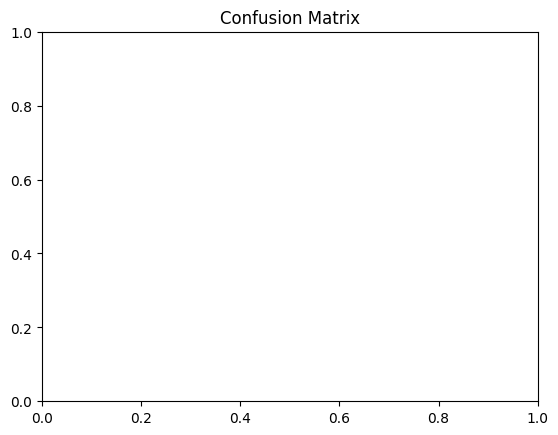

In [28]:
global_step = 0
best_mse = 1e5
num_epoch = 50 
phone_weight = 1.0
word_weight = 1.0
utterance_weight = 1.0
ckpt_dir = '/data/codes/apa/train/exps/test'

cur_lr = lr
for epoch in range(num_epoch):
    if epoch >= 10 and epoch % 3 == 0:
        cur_lr = (4 / 5) * cur_lr 
        for param_group in optimizer.param_groups:
            param_group['lr'] = cur_lr

    gopt_model.train()
    train_tqdm = tqdm(trainloader, "Training")
    for batch in train_tqdm:
        optimizer.zero_grad()

        features, phone_ids, word_ids, relative_positions,\
            phone_labels, word_labels, utterance_labels = to_device(batch, device)
        
        utterance_preds, phone_preds, word_preds = gopt_model(
            x=features.float(), phn=phone_ids.long(), rel_pos=relative_positions.long())
                
        loss_phn, loss_utt, loss_word = calculate_losses(
            phone_preds=phone_preds, 
            phone_labels=phone_labels, 
            word_preds=word_preds, 
            word_labels=word_labels, 
            utterance_preds=utterance_preds, 
            utterance_labels=utterance_labels)

        loss = phone_weight*loss_phn + word_weight*loss_word + utterance_weight*loss_utt
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gopt_model.parameters(), 1.0)
        
        optimizer.step()
        
        global_step += 1
        train_tqdm.set_postfix(
            lr=cur_lr,
            loss=loss.item(), 
            loss_phn=loss_phn.item(), 
            loss_word=loss_word.item(), 
            loss_utt=loss_utt.item())
    
    valid_result = validate(
        epoch=epoch, 
        gopt_model=gopt_model, 
        testloader=testloader, 
        best_mse=best_mse, 
        ckpt_dir=ckpt_dir)
    
    best_mse = valid_result["best_mse"]
    global_step += 1

In [29]:
# /data/codes/prep_ps_pykaldi_dev
# Training: 100%|██████████| 15329/15329 [01:16<00:00, 199.96it/s, loss=0.297, loss_phn=0.196, loss_utt=0.0429, loss_word=0.0582, lr=0.001]   
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.94      0.81      0.87     62804
#          1.0       0.18      0.57      0.27      6015
#          2.0       0.76      0.46      0.57     10979

#     accuracy                           0.74     79798
#    macro avg       0.63      0.61      0.57     79798
# weighted avg       0.86      0.74      0.79     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=0-mse=0.188400000333786
# ### Validation result (epoch=0)
#   Phone level:  MSE=0.188  MAE=0.267  PCC=0.730 
#    Word level:  MSE=0.132  MAE=0.273  PCC=0.740 
#     Utt level:  MSE=0.050  MAE=0.178  PCC=0.806 
# Training: 100%|██████████| 15329/15329 [01:15<00:00, 201.81it/s, loss=0.555, loss_phn=0.327, loss_utt=0.0926, loss_word=0.135, lr=0.001]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.81      0.88     62804
#          1.0       0.18      0.63      0.28      6015
#          2.0       0.80      0.42      0.55     10979

#     accuracy                           0.74     79798
#    macro avg       0.65      0.62      0.57     79798
# weighted avg       0.87      0.74      0.79     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=1-mse=0.17270000278949738
# ### Validation result (epoch=1)
#   Phone level:  MSE=0.173  MAE=0.271  PCC=0.754 
#    Word level:  MSE=0.126  MAE=0.276  PCC=0.758 
#     Utt level:  MSE=0.041  MAE=0.162  PCC=0.820 
# Training: 100%|██████████| 15329/15329 [01:16<00:00, 200.61it/s, loss=0.242, loss_phn=0.109, loss_utt=0.0581, loss_word=0.0744, lr=0.001]   
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.94      0.88      0.91     62804
#          1.0       0.21      0.53      0.30      6015
#          2.0       0.82      0.44      0.57     10979

#     accuracy                           0.79     79798
#    macro avg       0.66      0.62      0.59     79798
# weighted avg       0.87      0.79      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=2-mse=0.16619999706745148
# ### Validation result (epoch=2)
#   Phone level:  MSE=0.166  MAE=0.231  PCC=0.768 
#    Word level:  MSE=0.125  MAE=0.244  PCC=0.774 
#     Utt level:  MSE=0.049  MAE=0.172  PCC=0.822 
# Training: 100%|██████████| 15329/15329 [01:16<00:00, 200.61it/s, loss=0.24, loss_phn=0.23, loss_utt=0.00555, loss_word=0.00534, lr=0.001]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.85      0.90     62804
#          1.0       0.20      0.57      0.30      6015
#          2.0       0.80      0.49      0.61     10979

#     accuracy                           0.78     79798
#    macro avg       0.65      0.64      0.60     79798
# weighted avg       0.87      0.78      0.81     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=3-mse=0.16060000658035278
# ### Validation result (epoch=3)
#   Phone level:  MSE=0.161  MAE=0.242  PCC=0.773 
#    Word level:  MSE=0.114  MAE=0.246  PCC=0.778 
#     Utt level:  MSE=0.040  MAE=0.156  PCC=0.830 
# Training: 100%|██████████| 15329/15329 [01:31<00:00, 168.05it/s, loss=0.402, loss_phn=0.166, loss_utt=0.139, loss_word=0.0974, lr=0.001]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.96      0.82      0.89     62804
#          1.0       0.20      0.60      0.30      6015
#          2.0       0.79      0.53      0.63     10979

#     accuracy                           0.77     79798
#    macro avg       0.65      0.65      0.61     79798
# weighted avg       0.88      0.77      0.81     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=4-mse=0.1574999988079071
# ### Validation result (epoch=4)
#   Phone level:  MSE=0.157  MAE=0.239  PCC=0.780 
#    Word level:  MSE=0.114  MAE=0.242  PCC=0.778 
#     Utt level:  MSE=0.038  MAE=0.154  PCC=0.828 
# Training: 100%|██████████| 15329/15329 [01:27<00:00, 176.09it/s, loss=0.0829, loss_phn=0.0467, loss_utt=0.017, loss_word=0.0192, lr=0.001]   
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.87      0.90     62804
#          1.0       0.22      0.56      0.31      6015
#          2.0       0.81      0.50      0.62     10979

#     accuracy                           0.79     79798
#    macro avg       0.66      0.64      0.61     79798
# weighted avg       0.87      0.79      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=5-mse=0.1527000069618225
# ### Validation result (epoch=5)
#   Phone level:  MSE=0.153  MAE=0.225  PCC=0.785 
#    Word level:  MSE=0.111  MAE=0.232  PCC=0.788 
#     Utt level:  MSE=0.037  MAE=0.149  PCC=0.841 
# Training: 100%|██████████| 15329/15329 [01:23<00:00, 182.71it/s, loss=0.334, loss_phn=0.154, loss_utt=0.0811, loss_word=0.099, lr=0.001]     
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.86      0.90     62804
#          1.0       0.22      0.59      0.32      6015
#          2.0       0.81      0.51      0.62     10979

#     accuracy                           0.79     79798
#    macro avg       0.66      0.65      0.61     79798
# weighted avg       0.88      0.79      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=6-mse=0.1525000035762787
# ### Validation result (epoch=6)
#   Phone level:  MSE=0.152  MAE=0.224  PCC=0.787 
#    Word level:  MSE=0.112  MAE=0.237  PCC=0.784 
#     Utt level:  MSE=0.038  MAE=0.154  PCC=0.830 
# Training: 100%|██████████| 15329/15329 [02:07<00:00, 120.69it/s, loss=0.161, loss_phn=0.12, loss_utt=0.0158, loss_word=0.0253, lr=0.001]     
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.96      0.84      0.89     62804
#          1.0       0.21      0.60      0.31      6015
#          2.0       0.80      0.51      0.63     10979

#     accuracy                           0.78     79798
#    macro avg       0.65      0.65      0.61     79798
# weighted avg       0.88      0.78      0.81     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=7-mse=0.15219999849796295
# ### Validation result (epoch=7)
#   Phone level:  MSE=0.152  MAE=0.231  PCC=0.787 
#    Word level:  MSE=0.112  MAE=0.242  PCC=0.787 
#     Utt level:  MSE=0.038  MAE=0.155  PCC=0.842 
# Training: 100%|██████████| 15329/15329 [02:08<00:00, 119.03it/s, loss=0.334, loss_phn=0.261, loss_utt=0.0335, loss_word=0.0397, lr=0.001]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.87      0.91     62804
#          1.0       0.22      0.59      0.32      6015
#          2.0       0.84      0.45      0.59     10979

#     accuracy                           0.79     79798
#    macro avg       0.67      0.64      0.60     79798
# weighted avg       0.88      0.79      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=8-mse=0.15129999816417694
# ### Validation result (epoch=8)
#   Phone level:  MSE=0.151  MAE=0.228  PCC=0.788 
#    Word level:  MSE=0.112  MAE=0.229  PCC=0.789 
#     Utt level:  MSE=0.037  MAE=0.151  PCC=0.844 
# Training: 100%|██████████| 15329/15329 [02:09<00:00, 118.46it/s, loss=0.241, loss_phn=0.181, loss_utt=0.0142, loss_word=0.0458, lr=0.001]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.85      0.90     62804
#          1.0       0.21      0.61      0.31      6015
#          2.0       0.83      0.48      0.61     10979

#     accuracy                           0.78     79798
#    macro avg       0.67      0.65      0.61     79798
# weighted avg       0.88      0.78      0.81     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=9-mse=0.14949999749660492
# ### Validation result (epoch=9)
#   Phone level:  MSE=0.150  MAE=0.233  PCC=0.790 
#    Word level:  MSE=0.111  MAE=0.246  PCC=0.787 
#     Utt level:  MSE=0.038  MAE=0.154  PCC=0.840 
# Training: 100%|██████████| 15329/15329 [02:08<00:00, 119.00it/s, loss=0.172, loss_phn=0.0973, loss_utt=0.0401, loss_word=0.0346, lr=0.001]   
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.87      0.91     62804
#          1.0       0.22      0.59      0.32      6015
#          2.0       0.84      0.48      0.61     10979

#     accuracy                           0.80     79798
#    macro avg       0.67      0.64      0.61     79798
# weighted avg       0.88      0.80      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=10-mse=0.14650000631809235
# ### Validation result (epoch=10)
#   Phone level:  MSE=0.146  MAE=0.224  PCC=0.796 
#    Word level:  MSE=0.109  MAE=0.227  PCC=0.793 
#     Utt level:  MSE=0.037  MAE=0.150  PCC=0.839 
# Training: 100%|██████████| 15329/15329 [02:08<00:00, 119.33it/s, loss=0.242, loss_phn=0.143, loss_utt=0.0433, loss_word=0.0551, lr=0.001]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.86      0.90     62804
#          1.0       0.22      0.58      0.32      6015
#          2.0       0.81      0.52      0.63     10979

#     accuracy                           0.79     79798
#    macro avg       0.66      0.65      0.62     79798
# weighted avg       0.88      0.79      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=11-mse=0.147599995136261
# ### Validation result (epoch=11)
#   Phone level:  MSE=0.148  MAE=0.226  PCC=0.793 
#    Word level:  MSE=0.108  MAE=0.235  PCC=0.791 
#     Utt level:  MSE=0.035  MAE=0.147  PCC=0.843 
# Training: 100%|██████████| 15329/15329 [02:09<00:00, 118.09it/s, loss=0.192, loss_phn=0.134, loss_utt=0.0106, loss_word=0.0482, lr=0.0008]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.86      0.90     62804
#          1.0       0.21      0.59      0.31      6015
#          2.0       0.82      0.50      0.62     10979

#     accuracy                           0.79     79798
#    macro avg       0.66      0.65      0.61     79798
# weighted avg       0.88      0.79      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=12-mse=0.1467999964952469
# ### Validation result (epoch=12)
#   Phone level:  MSE=0.147  MAE=0.225  PCC=0.794 
#    Word level:  MSE=0.107  MAE=0.230  PCC=0.794 
#     Utt level:  MSE=0.036  MAE=0.146  PCC=0.842 
# Training: 100%|██████████| 15329/15329 [01:20<00:00, 191.55it/s, loss=0.159, loss_phn=0.117, loss_utt=0.013, loss_word=0.0296, lr=0.0008]     
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.88      0.91     62804
#          1.0       0.22      0.55      0.32      6015
#          2.0       0.81      0.50      0.62     10979

#     accuracy                           0.80     79798
#    macro avg       0.66      0.64      0.62     79798
# weighted avg       0.87      0.80      0.83     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=13-mse=0.14749999344348907
# ### Validation result (epoch=13)
#   Phone level:  MSE=0.148  MAE=0.214  PCC=0.795 
#    Word level:  MSE=0.108  MAE=0.225  PCC=0.793 
#     Utt level:  MSE=0.035  MAE=0.147  PCC=0.844 
# Training: 100%|██████████| 15329/15329 [01:17<00:00, 197.76it/s, loss=0.552, loss_phn=0.248, loss_utt=0.129, loss_word=0.175, lr=0.0008]      
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.87      0.91     62804
#          1.0       0.22      0.58      0.32      6015
#          2.0       0.82      0.51      0.63     10979

#     accuracy                           0.80     79798
#    macro avg       0.66      0.65      0.62     79798
# weighted avg       0.88      0.80      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=14-mse=0.14560000598430634
# ### Validation result (epoch=14)
#   Phone level:  MSE=0.146  MAE=0.219  PCC=0.797 
#    Word level:  MSE=0.107  MAE=0.232  PCC=0.795 
#     Utt level:  MSE=0.036  MAE=0.150  PCC=0.840 
# Training: 100%|██████████| 15329/15329 [01:17<00:00, 197.57it/s, loss=0.435, loss_phn=0.279, loss_utt=0.0316, loss_word=0.124, lr=0.00064]     
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.86      0.91     62804
#          1.0       0.22      0.58      0.32      6015
#          2.0       0.82      0.53      0.64     10979

#     accuracy                           0.80     79798
#    macro avg       0.66      0.66      0.62     79798
# weighted avg       0.88      0.80      0.83     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=15-mse=0.14309999346733093
# ### Validation result (epoch=15)
#   Phone level:  MSE=0.143  MAE=0.217  PCC=0.801 
#    Word level:  MSE=0.104  MAE=0.228  PCC=0.800 
#     Utt level:  MSE=0.034  MAE=0.143  PCC=0.850 
# Training: 100%|██████████| 15329/15329 [01:17<00:00, 197.73it/s, loss=0.657, loss_phn=0.295, loss_utt=0.14, loss_word=0.221, lr=0.00064]       
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.87      0.91     62804
#          1.0       0.22      0.58      0.32      6015
#          2.0       0.83      0.51      0.63     10979

#     accuracy                           0.80     79798
#    macro avg       0.67      0.65      0.62     79798
# weighted avg       0.88      0.80      0.83     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=16-mse=0.14429999887943268
# ### Validation result (epoch=16)
#   Phone level:  MSE=0.144  MAE=0.223  PCC=0.798 
#    Word level:  MSE=0.104  MAE=0.226  PCC=0.799 
#     Utt level:  MSE=0.035  MAE=0.144  PCC=0.849 
# Training: 100%|██████████| 15329/15329 [01:17<00:00, 198.20it/s, loss=0.406, loss_phn=0.141, loss_utt=0.0962, loss_word=0.169, lr=0.00064]     
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.86      0.91     62804
#          1.0       0.22      0.59      0.32      6015
#          2.0       0.82      0.52      0.63     10979

#     accuracy                           0.79     79798
#    macro avg       0.66      0.66      0.62     79798
# weighted avg       0.88      0.79      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=17-mse=0.14380000531673431
# ### Validation result (epoch=17)
#   Phone level:  MSE=0.144  MAE=0.223  PCC=0.799 
#    Word level:  MSE=0.105  MAE=0.229  PCC=0.797 
#     Utt level:  MSE=0.036  MAE=0.145  PCC=0.842 
# Training: 100%|██████████| 15329/15329 [01:17<00:00, 197.87it/s, loss=0.218, loss_phn=0.143, loss_utt=0.0215, loss_word=0.0538, lr=0.000512]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.86      0.90     62804
#          1.0       0.22      0.61      0.32      6015
#          2.0       0.83      0.50      0.63     10979

#     accuracy                           0.79     79798
#    macro avg       0.67      0.66      0.62     79798
# weighted avg       0.88      0.79      0.82     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=18-mse=0.14419999718666077
# ### Validation result (epoch=18)
#   Phone level:  MSE=0.144  MAE=0.224  PCC=0.799 
#    Word level:  MSE=0.105  MAE=0.223  PCC=0.800 
#     Utt level:  MSE=0.037  MAE=0.147  PCC=0.842 
# Training: 100%|██████████| 15329/15329 [01:17<00:00, 197.11it/s, loss=0.276, loss_phn=0.147, loss_utt=0.0119, loss_word=0.117, lr=0.000512]     
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.87      0.91     62804
#          1.0       0.22      0.57      0.32      6015
#          2.0       0.83      0.50      0.63     10979

#     accuracy                           0.80     79798
#    macro avg       0.67      0.65      0.62     79798
# weighted avg       0.88      0.80      0.83     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=19-mse=0.1446000039577484
# ### Validation result (epoch=19)
#   Phone level:  MSE=0.145  MAE=0.218  PCC=0.798 
#    Word level:  MSE=0.104  MAE=0.219  PCC=0.800 
#     Utt level:  MSE=0.036  MAE=0.145  PCC=0.843 
# Training: 100%|██████████| 15329/15329 [01:17<00:00, 197.46it/s, loss=0.232, loss_phn=0.0536, loss_utt=0.133, loss_word=0.0458, lr=0.000512]    
# ### F1 Score: 
#                precision    recall  f1-score   support

#          0.0       0.95      0.87      0.91     62804
#          1.0       0.22      0.58      0.32      6015
#          2.0       0.82      0.51      0.63     10979

#     accuracy                           0.80     79798
#    macro avg       0.67      0.65      0.62     79798
# weighted avg       0.88      0.80      0.83     79798

# Save state dict and result to /data/codes/apa/train/exps/scores/ckpts-eph=20-mse=0.1444000005722046
# ### Validation result (epoch=20)
#   Phone level:  MSE=0.144  MAE=0.216  PCC=0.799 
#    Word level:  MSE=0.105  MAE=0.227  PCC=0.797 
#     Utt level:  MSE=0.036  MAE=0.147  PCC=0.842 
# Training:  88%|████████▊ | 13439/15329 [01:09<00:09, 199.14it/s, loss=0.34, loss_phn=0.175, loss_utt=0.0896, loss_word=0.0752, lr=0.00041]     